# **Assignment 2: Logistic Regression**
The goals of this assignment are as follows:
-   Implement a logistic regression algorithm following Elements of Statistical Learning Chapter 4 and Andrew Ng's CS229 Notes. Following functions are realized in the regression function:
  - Unregularized Logistic Regression
  - L1 regularized Logistic Regression
  - L2 regularized Logistic Regression
  - Forward Stepwise Feature Selection 
- Fit a unregularized,a L2 regularized, and a stepwise model for the South African Heart disease dataset. Report the accuracies.
- Stretch Goal 1 - Implement L1 regularization, and produce a lasso feature selection like feature vs lambda plot, indicate most important feature.
- Stretch Goal 2 - Implement Multinomial logistic regression, and fit model using UCI IRIS dataset. Report model accuracy.

##  **Logistic regression using stochastic gradient descent,  and all the supplementary functions**
This sections refers to Elements of Statistical Learning Chapter 4, as well as Andrew Ng's CS229 notes on logistic regression

*   Hypothesis
*   Log Likelihood (No regularization, L2, L1)
*   Logistic Regression
*   Accuracy Score


Def h(x, theta):
Return 1/(1+e^theta.T*x)

Def Likelihood:
	P(y,x,theta) = h(x,theta)^y * (1-h(x,theta))^-y
	Return P.prod()

Logistic regression(x,y,theta,alpha): 
	For(i = 0:data_Set.row number):
		For(j = 0:theta.size)
			Theta_j = theta_j+ alpha*(y^I – h(x^I,theta))*x^i_j


In [ ]:
'''
Logistic regression is trained using stochastic gradient descent. A detailed
description of this methods is given in Andrew Ng's cs229-notes1, page 18-19.
'''

def standardize(input_df): #Subtract mean and divide by std to scale data
  input_df = (input_df.subtract(input_df.mean())).divide(input_df.std(ddof=0))
  return input_df

def h(x,theta):
  '''
  Hypothesis function using sigmoid function. Andrew Ng page 18
  Output y = {0,1} as a column
  input theta and x as row vectors
  '''
  z = x @ theta.T
  return 1/(1+np.exp(-z))

def loglikelihood(x,y,theta):
  '''
  Log likelihood estimate. Andrew Ng page 18
  Input entire dataframe, labels, returns log likelihood as a scaler
  Loglikihood summation is computed in regression()
  '''
  a = np.log(h(x,theta).T) @ y
  b = np.log(1-h(x,theta)) @ (1-y)
  value = (a+b).sum()

  # Equivalent none vector form
  # value = 0; rows = x.shape[0] 
  # for i in range(0,rows):
  #   value += (y[i]*np.log(h(x.iloc[i,:],theta)))+((1-y[i])*np.log(1-h(x.iloc[i,:],theta)))
  return value

def regression(x,y,alpha,intercept=True, _type=None,_lambda=None,_plot=True):
  """
  Logistic regression. Outputs coefficient of weights with intercept and max likelihood. Also plots maximum log likelihood
  Input is feature, label, what type of regularization, and hyperparameter _lambda
  """
  if (intercept == True):
    try:
      x.insert(0,'Constant',np.ones((x.shape[0],1))) #Insert ones to first column of training features
    except:
      pass
  num_feature = x.shape[1]
  theta=np.zeros([num_feature]) # Create row vector, size of [1,num_feature]
  _loglikelihood = []; num_iterations = []; thetas = np.reshape(theta,[1,theta.shape[0]]);

  cur_theta = theta
  cur_likelihood = 0
  '''
  Stochastic gradient descent (Andrew Ng's CS229 Lecture Notes, pg 19)
  θj:= θj + α* (y(i) − hθ(x(i))x(i,j)
  Implemented in vector form
  '''
  rows = x.shape[0]
  for i in range(0,rows):
    if _type == None:
      cur_theta += (alpha*(y.iloc[i] - h(x.iloc[i,:],theta)))*x.iloc[i,:]
    elif _type == 'L1':
      cur_theta += (alpha*(y.iloc[i] - h(x.iloc[i,:],theta)))*x.iloc[i,:] - 2*_lambda*cur_theta
    elif _type == 'L2':
      cur_theta += (alpha*(y.iloc[i] - h(x.iloc[i,:],theta)))*x.iloc[i,:] - 2*_lambda*np.sign(cur_theta)
    else:
      raise "Specified Method Not Implemented\n"

    _loglikelihood.append(loglikelihood(x,y,cur_theta))
    num_iterations.append(i)
    thetas = np.concatenate((thetas,np.reshape(cur_theta.values,[1,cur_theta.shape[0]])), axis = 0)

  # Find max loglilihood and extrat weight at max ll
  thetas = thetas[1:,:]
  max_loglikelihood = np.nanmax(_loglikelihood)
  idx = np.nanargmax(_loglikelihood)

   # Plots likelihood vs iterations
  if _plot == True:
    plt.figure(figsize=(9,6))
    for i in range(0,len(_loglikelihood)):
        plt.scatter(num_iterations,_loglikelihood,color='#FAB18E',marker='.')
    plt.axvline(x=idx,linestyle='--',color='#FF3333')
    plt.xlabel("Iterations")
    plt.ylabel("Log Likelihood L(theta)")
    plt.title(f"Likelihood vs Iteration α={alpha}, iter={num_iterations[len(num_iterations)-1]}, λ={_lambda}, Regularization type = {_type}")
    plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) # format xlabel as int precision
    plt.show()
  
  print(f"Max log(L) = {max_loglikelihood.round(3)}, Idx = {idx}")
  return {"weights":thetas[idx,:], "max likelihood":max_loglikelihood}

def score(test_feat,test_label,theta,intercept=True,print_output = False):
  """
  Accuracy of label from logistic regression to actual label
  test_feat, label, theta all as cols
  """
  correct = 0
  if intercept == True:
    try:
      test_feat.insert(0,'Constant',np.ones((test_feat.shape[0],1))) #Insert ones to first column of training features
    except:
      pass
  pred = h(test_feat,theta)
  pred[pred>=0.5] = 1
  pred[pred<0.5] = 0
  num_correct = 0
  for i in range(0,test_label.shape[0]):
    if(pred.iloc[i] == test_label.iloc[i]):
      num_correct += 1
  accuracy = num_correct/test_label.shape[0]
  if(print_output == True):
    print(f"Accuracy of current model is {round(accuracy,2)}\n")
  return accuracy


def forward_stepwise(x_train,y_train,x_validation,y_validation,feature_names):
  """
  determines which features are important. uses x_train and y_train to determine optimal weights in a descending order (1st feature that appears is most important).
  then uses x_validation and y_validation to score each iteration using cross validation. highest score results in the optimal features.
  """
  actual_weights = {}
  good_features = ['']*len(feature_names)
  max_score = 0
  print('------------------------------------')
  for j in range(len(feature_names)):
    predicted_weight = np.zeros(len(feature_names))
    if j == 0:
      for i in range(len(feature_names)):
        predicted_weight[i] = regression(x_train[[feature_names[i]]],y_train,0.03,intercept=True,_type=None,_lambda=None,_plot=False)["weights"][j+1] #doesn't account for intercept
        #print("finished")
    else:
      for i in range(len(feature_names)):
        kept_features.append(feature_names[i])
        #print(kept_features) #returns what features are being tested in this loop
        predicted_weight[i] = regression(x_train[kept_features],y_train,0.03,intercept=True,_type=None,_lambda=None,_plot=False)["weights"][j+1] #doesn't account for intercept
        #print("finished")  
        kept_features.remove(feature_names[i])

    # Score current features with validation set
    # cur_score_features = validation[features the current model selected]
    # cur_accuracy = score(cur_score_features, validation_labels,cur_thete)
    # (cur_theta is tarined using training set)
    
    # if(cur_accuracy > max_accuracy):
    #     final_weights = cur_weight
    #     max_accuracy = cur_accuracy

    #print(predicted_weight) #returns weights of each features for the jth loop 
    a =  np.argmax([predicted_weight]) #removes the intercept
    actual_weights[feature_names[a]] = predicted_weight[a]
    good_features[j] = feature_names.pop(a)
    kept_features = good_features[0:j+1]
    print(f"Feature {j} determined")
    #print(actual_weights) #returns dictionary of overall predominant features
    #print(good_features) #returns features in descending order
    #display(x_train[kept_features].head())
    theta = regression(x_train[kept_features],y_train,0.01,intercept=True, _type=None,_lambda=None,_plot=False)["weights"]
    max_score = score(x_validation[kept_features],y_validation,theta,intercept=True,print_output=False)
    print(kept_features)
    print(f"Accuracy with only {kept_features} is {round(max_score*100,2)}%")
    print('------------------------------------')

## **African Heart Disease Dataset**

###Relevant Imports and Creating Dataframes

In [ ]:
"""
Below are all the imports and then creating the dataframe used for this assignment by scraping the provided website
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.ticker import StrMethodFormatter
from sklearn.linear_model import LogisticRegression
import operator
import seaborn

cmap = plt.cm.Spectral
cnorm = plt.Normalize(vmin=0, vmax=1)

df = pd.read_csv("https://web.stanford.edu/~hastie/ElemStatLearn/datasets/SAheart.data") #shape of (462,11)
famhist = {"Present": 1,"Absent": 0}
df["famhist"] = df["famhist"].map(famhist) #changes "famhist" feature into binary
df = df.sample(frac=1,random_state=1).reset_index().drop(['index','row.names'],axis=1) #randomize rows and drop unnecessary cols, shape of (462,10)
df_plot = df.copy()

"""
The column of interest is "chd" which is a binary result of whether one has heart disease as 0 is no and 1 is yes
"""

label_col = df.pop("chd")
df = standardize(df)

train_feat = df[:369] #Split training, test, and validation set, 80% training, 10% each for test and validation
test_feat = df[370:415]
validation_feat = df[416:]

train_label = label_col[:369] # Labels Setup
test_label = label_col[370:415]
validation_label = label_col[416:]

# display(test_feat,test_label)

### Scatter matrix of the South African Heart Disease Dataset
This section replicates figure 4.12 of textbook

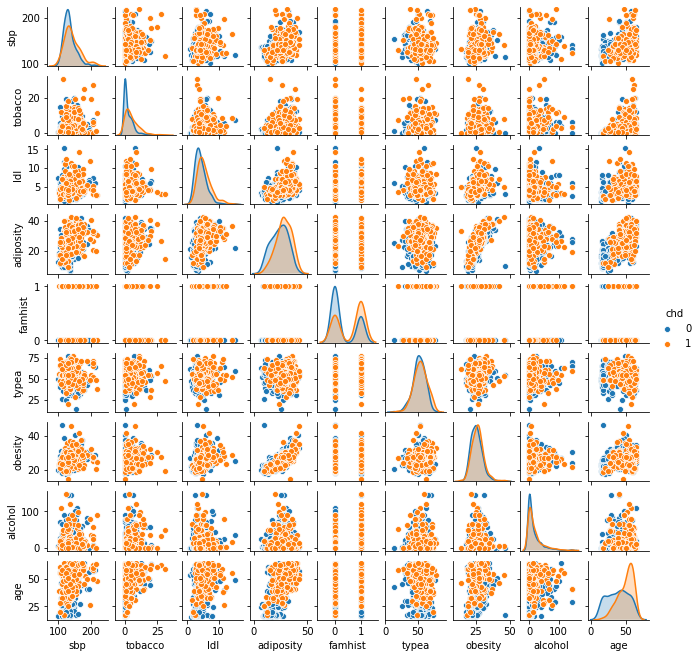

In [ ]:
# Method 1 Plotting with pandas.pairplot
# scatter_df = df.drop(['chd'],axis=1)
# scatter_df_color = df.loc[:,'chd']

# scatter_df_color[scatter_df_color == 1] = "#ff0000"
# scatter_df_color[scatter_df_color == 0] = "#00ced1"

# _ = pd.plotting.scatter_matrix(scatter_df,figsize=[15,15],edgecolors = scatter_df_color ,marker='o',facecolors='none')

# Method 2 Seaborn pairplot
seaborn.pairplot(df_plot, hue = "chd", kind='scatter', diag_kind='kde', height=1, 
                 aspect=1, corner=False, dropna=False, plot_kws=None, diag_kws=None, grid_kws=None, size=None)

### Generating logistic regression models 
Three models are generated here: 
- Unregularized
- L1 regularized
- L2 regularized. 
- Forward Stepwise

A log likelihood versus iterations plot is plotted for each model, as well as accuracy reported individually. A baseline accuracy is also reported.


### Forward step wise logistic regression with cross valiation
Using forward stepwise to determine how each feature contribute to the overall model, or to select features that are most important. Accuracy of each feature set computed using validation set.

In [ ]:
# Note, forward stepwise block is here. This is due to using a visual inspection (print statements) to determine
# which features is predominant when using forward stepwise to determine weights from the training set.
# Cross-validation is used to determine accuracy. 
# This is due to the most predominant feature (Accuracy with only ['age'] is 67.39%) being greater than all other trials.
# In this case, the most predominant features with the next highest accuracy is (Accuracy with only ['age', 'famhist', 'tobacco'] is 65.22%) 
features = ["sbp","tobacco","ldl","adiposity","famhist","typea","obesity","alcohol","age"]
forward_stepwise(train_feat,train_label,validation_feat,validation_label,features)

selected_features = ['age', 'famhist', 'tobacco']

------------------------------------
Max log(L) = -233.054, Idx = 140
Max log(L) = -220.043, Idx = 140
Max log(L) = -222.591, Idx = 138
Max log(L) = -220.974, Idx = 176
Max log(L) = -222.975, Idx = 134
Max log(L) = -235.234, Idx = 135
Max log(L) = -233.294, Idx = 152
Max log(L) = -237.209, Idx = 98
Max log(L) = -212.158, Idx = 184
Feature 0 determined
Max log(L) = -215.103, Idx = 366
['age']
Accuracy with only ['age'] is 67.39%
------------------------------------
Max log(L) = -213.753, Idx = 137
Max log(L) = -208.595, Idx = 98
Max log(L) = -206.456, Idx = 135
Max log(L) = -211.381, Idx = 135
Max log(L) = -204.857, Idx = 137
Max log(L) = -207.175, Idx = 211
Max log(L) = -212.546, Idx = 174
Max log(L) = -211.869, Idx = 199
Feature 1 determined
Max log(L) = -204.997, Idx = 366
['age', 'famhist']
Accuracy with only ['age', 'famhist'] is 63.04%
------------------------------------
Max log(L) = -204.465, Idx = 98
Max log(L) = -198.857, Idx = 92
Max log(L) = -199.45, Idx = 92
Max log(L) = -2

### A comparision between nonregularized, L1 regularized and L2 regularized logistic regression

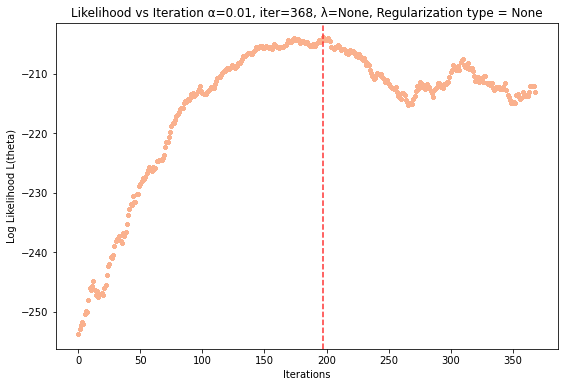

Max log(L) = -203.877, Idx = 197


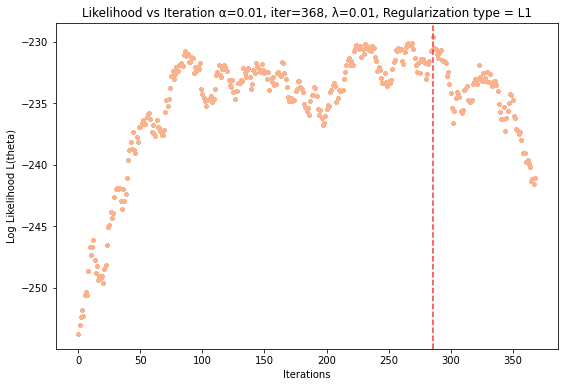

Max log(L) = -229.649, Idx = 286


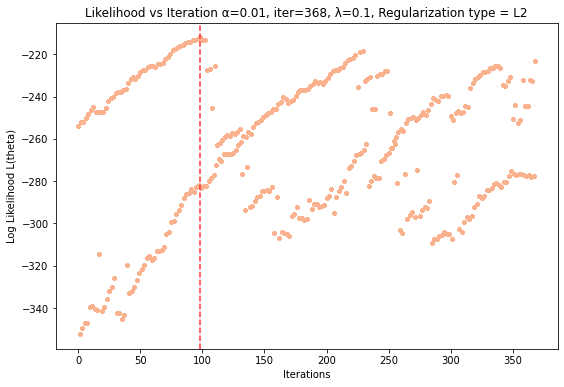

Max log(L) = -212.08, Idx = 98


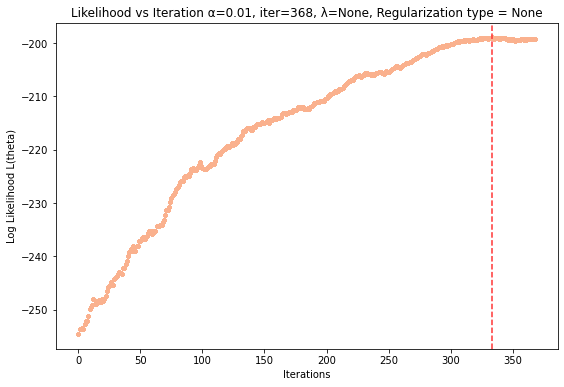

Max log(L) = -198.943, Idx = 333


In [ ]:
'''
Logistic regression with no regulariztion, forward stepwise, L1 and L2 regularization. 
All models scored against test set
Computes a baseline (mean of label)
'''
selected_features = ['age', 'famhist', 'tobacco'] #See above cell for how this was determined

noreg_weight = regression(train_feat,train_label,0.01,_type=None,_lambda=None)["weights"]
L1reg_weight = regression(train_feat,train_label,0.01,_type="L1",_lambda=0.01)["weights"]
L2reg_weight = regression(train_feat,train_label,0.01,_type="L2",_lambda=0.1)["weights"]
stepwise_weight = regression(train_feat[selected_features], train_label,0.01,_type=None,_lambda=None)["weights"]
# ["Intercept","sbp","tobacco","ldl","adiposity","famhist","typea","obesity","alcohol","age"]

baseline = test_label.mean()
accuracy_noreg = score(test_feat,test_label,noreg_weight)
accuracy_L1reg = score(test_feat,test_label,L1reg_weight)
accuracy_L2reg = score(test_feat,test_label,L2reg_weight)
accuracy_stepwise = score(test_feat[selected_features],test_label,stepwise_weight)

### Sweeping Lambda to Find Coefficients for L1 and L2
And coeff vs lambda plots, lasso and ridge regression style

In [ ]:
_lambda_array = np.linspace(0,0.2,20)
L1_coef = np.zeros((len(_lambda_array),10))
L2_coef = np.zeros((len(_lambda_array),10))
columns_label = df.columns[0:9]

for i in range(len(_lambda_array)):
  L1_coef[i] = regression(train_feat,train_label,0.01,intercept=False,_type="L1",_lambda=_lambda_array[i],_plot=False)["weights"]
  L2_coef[i] = regression(train_feat,train_label,0.01,intercept=False,_type="L2",_lambda=_lambda_array[i],_plot=False)["weights"]

Max log(L) = -203.877, Idx = 197
Max log(L) = -203.877, Idx = 197
Max log(L) = -230.58, Idx = 286
Max log(L) = -250.752, Idx = 253
Max log(L) = -239.558, Idx = 86
Max log(L) = -244.929, Idx = 12
Max log(L) = -243.696, Idx = 86
Max log(L) = -241.637, Idx = 200
Max log(L) = -245.874, Idx = 224
Max log(L) = -238.047, Idx = 34
Max log(L) = -247.294, Idx = 76
Max log(L) = -232.035, Idx = 200
Max log(L) = -248.218, Idx = 76
Max log(L) = -224.22, Idx = 68
Max log(L) = -248.916, Idx = 76
Max log(L) = -221.432, Idx = 72
Max log(L) = -249.474, Idx = 76
Max log(L) = -217.705, Idx = 78
Max log(L) = -249.939, Idx = 76
Max log(L) = -213.351, Idx = 94
Max log(L) = -250.295, Idx = 75
Max log(L) = -211.735, Idx = 110
Max log(L) = -250.602, Idx = 75
Max log(L) = -209.066, Idx = 120
Max log(L) = -250.873, Idx = 75
Max log(L) = -205.973, Idx = 142
Max log(L) = -251.092, Idx = 9
Max log(L) = -205.3, Idx = 146
Max log(L) = -251.252, Idx = 9
Max log(L) = -204.449, Idx = 170
Max log(L) = -251.396, Idx = 9
Max

Text(0, 0.5, 'Weights')

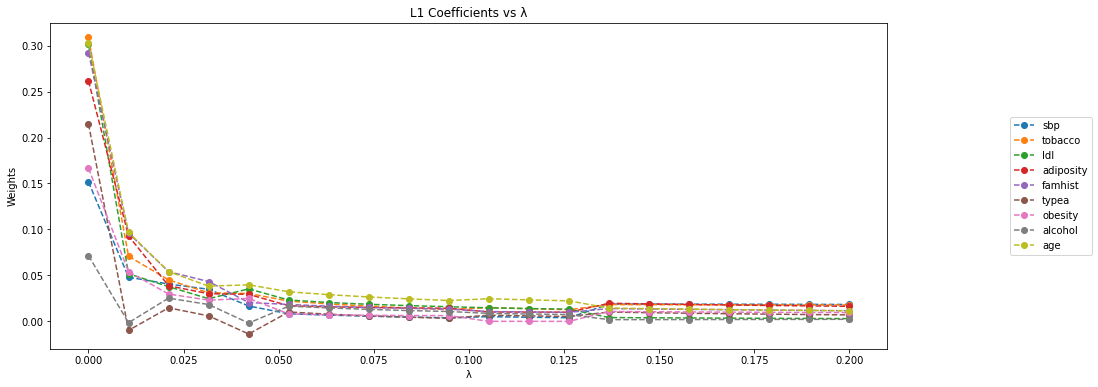

In [ ]:
plt.figure(figsize=[15,6])
for i in range(L1_coef.shape[1]-1):
  x = L1_coef[:,i+1]
  plt.plot(_lambda_array,x,label=columns_label[i],linestyle='--', marker='o')

plt.title("L1 Coefficients vs λ")
plt.legend(loc="right",bbox_to_anchor=(1.25, 0.5))
plt.xlabel("λ")
plt.ylabel("Weights")

Text(0, 0.5, 'Weights')

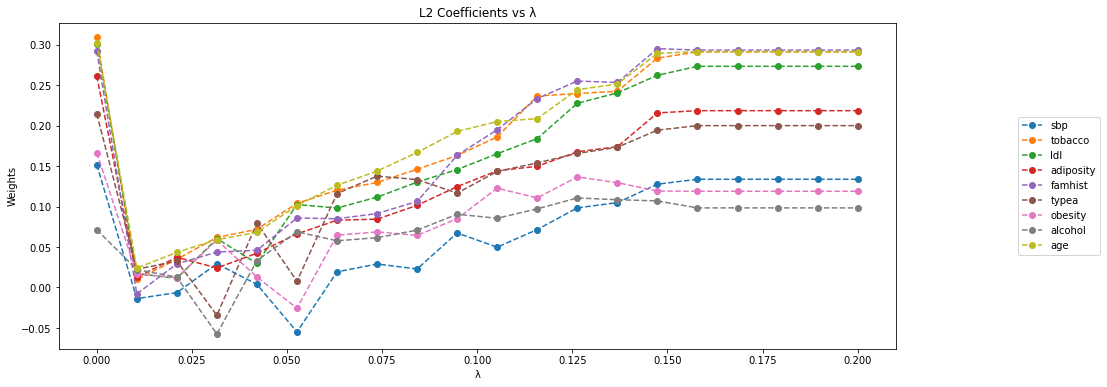

In [ ]:
plt.figure(figsize=[15,6])
for i in range(L2_coef.shape[1]-1):
  y = L2_coef[:,i+1]
  plt.plot(_lambda_array,y,label=columns_label[i],linestyle='--', marker='o')

plt.title("L2 Coefficients vs λ")
plt.legend(loc="right",bbox_to_anchor=(1.25, 0.5))
plt.xlabel("λ")
plt.ylabel("Weights")

**### Determining Lambda Based off Validation Set**


### Coefficient Table for All 4 Methods

In [ ]:
table_3_2_rows = ["Intercept","sbp","tobacco","ldl","adiposity","famhist","typea","obesity","alcohol","age"]
stepwise_weight_changed = [stepwise_weight[0],"0",stepwise_weight[3],"0","0",stepwise_weight[2],"0","0","0",stepwise_weight[1]] #this is hard-coded based on random state

table_3_2 = {"No Regularization": noreg_weight,
            "L1": L1reg_weight,
            "L2": L2reg_weight,
            "Stepwise": stepwise_weight_changed
            }

df_table_3_2 = pd.DataFrame(table_3_2, index=table_3_2_rows)
df_table_3_2.style

,No Regularization,L1,L2,Stepwise
Intercept,-0.277905,-0.104866,-0.192844,-0.565884
sbp,0.151695,0.050575,0.055934,0
tobacco,0.308947,0.074301,0.166844,0.488199
ldl,0.301364,0.054912,0.147729,0
adiposity,0.261525,0.097742,0.133921,0
famhist,0.292292,0.099864,0.181812,0.536088
typea,0.214718,-0.009610,0.114664,0
obesity,0.166528,0.056950,0.091888,0
alcohol,0.071375,-0.001107,0.077742,0
age,0.302705,0.101416,0.203551,0.583127


### Accuracy Table for All 4 Methods and Weights of Step wise

In [ ]:
print("-------------Accuracy Table-------------")
baseline = test_label.mean()


accuracy_array = [baseline*100, accuracy_noreg*100, accuracy_L1reg*100, accuracy_L2reg*100, accuracy_stepwise*100]
accuracy_header = {"Accuracy (%)": accuracy_array}
accuracy_row = ["Baseline","No Reg", "L1", "L2", "Stepwise"]
df_accuracy = pd.DataFrame(accuracy_header, index=accuracy_row)
display(df_accuracy)

-------------Accuracy Table-------------


,Accuracy (%)
Baseline,35.555556
No Reg,77.777778
L1,77.777778
L2,77.777778
Stepwise,80.000000


### Analysis

For this African Heart Disease dataset, all methods (no regularization, L1, L2, and Forward Stepwise) outperformed the baseline value. The method with the overall highest accuracy is Forward Stepwise. Forward stepwise determined that the predominant features are "age", "famhist" and "tabacco", which makes physical sense. When you are older, you are more preceptible to diseases/illnesses. Family history is important in dictating whether one is inclined to have a certain condition/disease. Tabacco is used to make tobacco, which isn't really good for your heart. Our created forward stepwise model did exclude "ldl" compared to the textbook, which would have been the next predominant feature, yet made a decrease in accuracy.  Inspecting the coefficient table, "age", "famhist", and "tabacco" all contain the highest weights in each method, albeit for no regularization there are other features with close values. The log likelihood plots were also determined, which told one the maximum value, which in turn tells the ideal weights. The L2 plot was very sporadic, while L1 seems to jump around a central value then decrease, with no regularization and stepwise achieving a consistent max value.

## **Logistic Regression On an External Dataset**
We chose the UCI occupancy dataset. The occupancy dataset is a bilinear dataset that contains features consisting of :
- date time year-month-day hour:minute:second
- Temperature, in Celsius
- Relative Humidity, %
- Light, in Lux
- CO2, in ppm
- Humidity Ratio, Derived quantity from temperature and relative humidity, in kgwater-vapor/kg-air

And a lable: Occupancy, 0 or 1, 0 for not occupied, 1 for occupied status
There are in total more then 10,000 observations available in this data frame. However, since the logistic regression is not optimized for large datasets, we will use the 2,600 rows "datatest.txt" as our sample, with a 0.6:0.2:0.2 train - validation - test split.

### Importing relavent librairies and dataframe. Split test, train and validation features and lables.

In [ ]:
import requests
import zipfile
from urllib.request import urlopen
from io import BytesIO
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn
from sklearn.model_selection import train_test_split

#http://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+
"""
date (timestamp and date) -- Input Variable
Temperature -- Input Variable
Humidity -- Input Variable
Light -- Input Variable
CO2 -- Input Variable
HumidityRatio -- Input Variable
Occupancy -- Output Variable (binary classification)
"""
#source to import multiple files from online zip file: https://github.com/zooniverse/planet-four/issues/185
zip_file_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00357/occupancy_data.zip'
remote_zip_file = urlopen(zip_file_url)
zipinmemory = BytesIO(remote_zip_file.read())
zip_file = zipfile.ZipFile(zipinmemory)
df = pd.read_csv(zip_file.open(zip_file.namelist()[0])) #['datatest.txt', 'datatest2.txt', 'datatraining.txt'], shapes of 2665, 9752, 8143 
df = df.sample(frac=1,random_state=7).reset_index().drop(['index','date'],axis=1) #randomize rows and removes the time series feature (consists of the date and time of day)

# df_plot = df.copy()
df_plot = df.copy()
"""
The column of interest is "Occupancy" which is a binary result of whether someone is in the room as 0 is no and 1 is yes
"""
label_col = df.pop("Occupancy")
#df.drop(["date"], axis=1, inplace=True)
df = standardize(df)


#x_train = df[:10] # 10 observations, fast debug
x_train = df[:1599] #Split training, test, and validation set, 80% training, 10% each for test and validation
x_test = df[1600:2133]
x_validation = df[2134:]

#y_train = label_col[:10] # 10 observations, fast debug
y_train = label_col[:1599] # Labels Setup
y_test = label_col[1600:2133]
y_validation = label_col[2134:]


### Scatter matrix of the Occupancy
This section replicates figure 4.12 of textbook

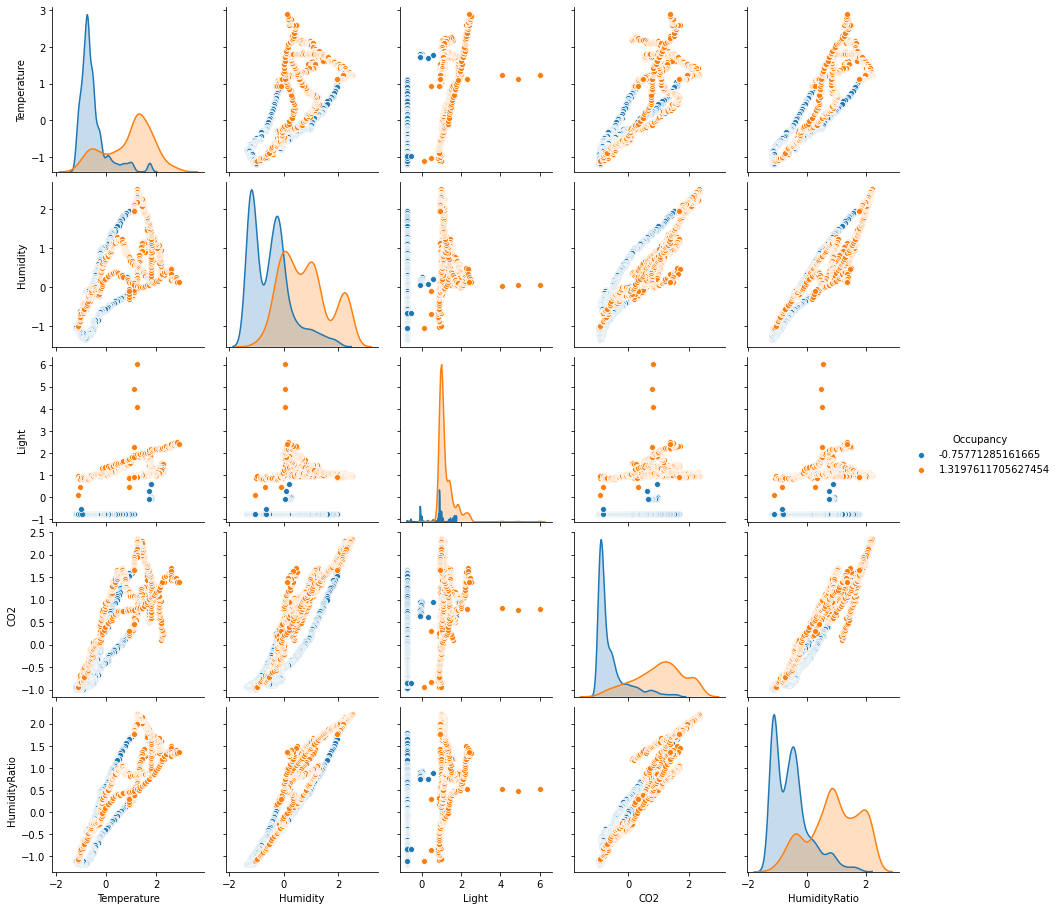

In [ ]:
seaborn.pairplot(df_plot, hue = "Occupancy", kind='scatter', diag_kind='kde', height=2.5, 
                 aspect=1, corner=False, dropna=False, plot_kws=None, diag_kws=None, grid_kws=None, size=None)

### Generating logistic regression models 
Three models are generated here: 
- Unregularized
- L1 regularized
- L2 regularized. 

A log likelihood versus iterations plot is plotted for each model, as well as accuracy reported individually. A baseline accuracy is also reported.


### Forward step wise logistic regression with cross valiation
Using forward stepwise to determine how each feature contribute to the overall model, or to select features that are most important. Accuracy of each feature set computed using validation set.

In [ ]:
# Note, forward stepwise block is here. This is due to using a visual inspection (print statements) to determine
# which features is predominant when using forward stepwise to determine weights from the training set.
# Cross-validation is used to determine accuracy. 
# This is due to the most predominant feature (Accuracy with only ['Light'] is 98.68%) being greater than all other trials.
features_occ = ["Temperature","Humidity","Light","CO2","HumidityRatio"]
display(x_train)
forward_stepwise(x_train,y_train,x_validation,y_validation,features_occ)

,Temperature,Humidity,Light,CO2,HumidityRatio
0,-0.139980,0.999868,-0.772404,0.219028,0.529153
1,-0.648332,-0.145271,-0.772404,-0.668621,-0.394411
2,1.368049,0.470395,1.829890,1.039186,0.874337
3,-0.553472,0.004541,0.978448,-0.135519,-0.265178
4,-0.811297,-1.294515,-0.772404,-0.906410,-1.149636
...,...,...,...,...,...
1594,-0.908589,-0.514671,-0.772404,-0.856289,-0.717327
1595,0.064333,1.180463,-0.772404,0.484440,0.737222
1596,-0.397805,0.394463,-0.772404,-0.295279,0.038873
1597,-0.714005,-0.093966,-0.772404,-0.736968,-0.389230


------------------------------------


/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Max log(L) = -598.092, Idx = 197
Max log(L) = -703.773, Idx = 193
Max log(L) = -152.915, Idx = 324
Max log(L) = -482.109, Idx = 235
Max log(L) = -585.484, Idx = 222
Feature 0 determined
Max log(L) = -154.711, Idx = 963
['Light']
Accuracy with only ['Light'] is 98.68%
------------------------------------
Max log(L) = -230.989, Idx = 188
Max log(L) = -166.748, Idx = 270
Max log(L) = -183.734, Idx = 202
Max log(L) = -190.847, Idx = 208
Feature 1 determined
Max log(L) = -168.833, Idx = 824
['Light', 'Humidity']
Accuracy with only ['Light', 'Humidity'] is 98.12%
------------------------------------
Max log(L) = -275.355, Idx = 119
Max log(L) = -259.579, Idx = 119
Max log(L) = -281.955, Idx = 119
Feature 2 determined
Max log(L) = -264.119, Idx = 445
['Light', 'Humidity', 'CO2']
Accuracy with only ['Light', 'Humidity', 'CO2'] is 93.22%
------------------------------------
Max log(L) = -328.92, Idx = 112
Max log(L) = -337.513, Idx = 110
Feature 3 determined
Max log(L) = -345.736, Idx = 271
['L

### A comparision between nonregularized, L1 regularized and L2 regularized logistic regression

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


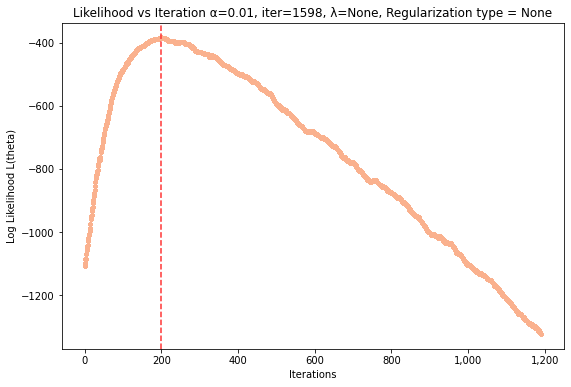

Max log(L) = -383.698, Idx = 199


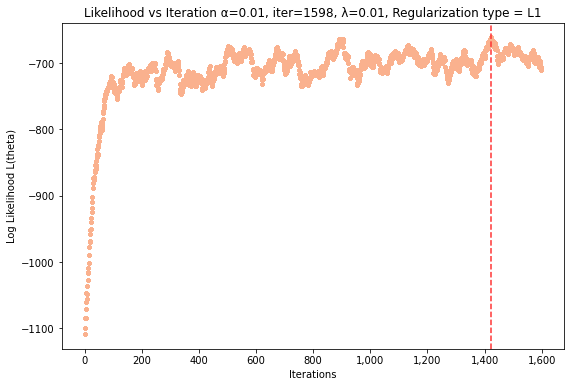

Max log(L) = -661.169, Idx = 1423


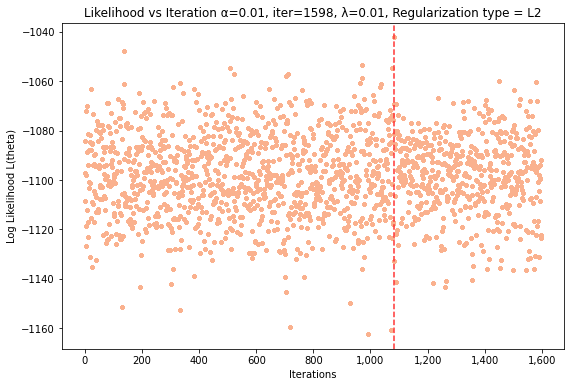

Max log(L) = -1042.255, Idx = 1081


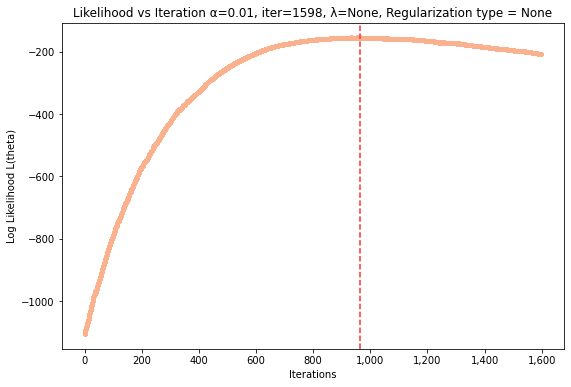

Max log(L) = -154.711, Idx = 963

----------------------------------

Baseline accuracy is 36.96%
Unregularized scored 86.12%
L1 regularized scored 86.12%
L2 regularized scored 84.62%
Forward stepwise scored 97.75%


In [ ]:
'''
Logistic regression with no regulariztion, forward stepwise, L1 and L2 regularization. 
All models scored against test set
Computes a baseline (mean of label)
'''
selected_feature_occ = ["Light"]

noreg_weight = regression(x_train,y_train,0.01,intercept=True,_type=None,_lambda=None)["weights"]
L1reg_weight = regression(x_train,y_train,0.01,intercept=True,_type="L1",_lambda=0.01)["weights"]
L2reg_weight = regression(x_train,y_train,0.01,intercept=True,_type="L2",_lambda=0.01)["weights"]
stepwise_weight = regression(x_train[selected_feature_occ],y_train,0.01,_type=None,_lambda=None)["weights"]

print("\n----------------------------------\n")
baseline = y_test.mean()
noreg_score = score(x_test,y_test,noreg_weight)
L1_score = score(x_test,y_test,L1reg_weight)
L2_score = score(x_test,y_test,L2reg_weight)
stepwise_score = score(x_train[selected_feature_occ],y_train,stepwise_weight)

print(f"Baseline accuracy is {round(baseline*100,2)}%")
print(f"Unregularized scored {round(noreg_score*100,2)}%")
print(f"L1 regularized scored {round(L1_score*100,2)}%")
print(f"L2 regularized scored {round(L2_score*100,2)}%")
print(f"Forward stepwise scored {round(stepwise_score*100,2)}%")

### Sweeping Lambda to Find Coefficients for L1 and L2
And coeff vs lambda plots, lasso and ridge regression style

In [ ]:
_lambda_array = np.linspace(0,0.2,10)
L1_coef = np.zeros((len(_lambda_array),6)) #5 features, 1 intercept
L2_coef = np.zeros((len(_lambda_array),6)) #5 features, 1 intercept
columns_label = df.columns

for i in range(len(_lambda_array)):
  L1_coef[i] = regression(x_train,y_train,0.01,intercept=False,_type="L1",_lambda=_lambda_array[i],_plot=False)["weights"]
  L2_coef[i] = regression(x_train,y_train,0.01,intercept=False,_type="L2",_lambda=_lambda_array[i],_plot=False)["weights"]

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Max log(L) = -383.698, Idx = 199
Max log(L) = -383.698, Idx = 199
Max log(L) = -848.444, Idx = 891
Max log(L) = -994.347, Idx = 872
Max log(L) = -954.694, Idx = 670
Max log(L) = -907.022, Idx = 508
Max log(L) = -994.024, Idx = 670
Max log(L) = -840.24, Idx = 28
Max log(L) = -1015.995, Idx = 670
Max log(L) = -732.542, Idx = 965
Max log(L) = -1030.323, Idx = 670
Max log(L) = -709.524, Idx = 48
Max log(L) = -1040.495, Idx = 670
Max log(L) = -637.843, Idx = 1555
Max log(L) = -1048.121, Idx = 670
Max log(L) = -590.483, Idx = 68
Max log(L) = -1054.073, Idx = 670
Max log(L) = -556.502, Idx = 76
Max log(L) = -1058.867, Idx = 670
Max log(L) = -518.935, Idx = 86


Text(0, 0.5, 'Weights')

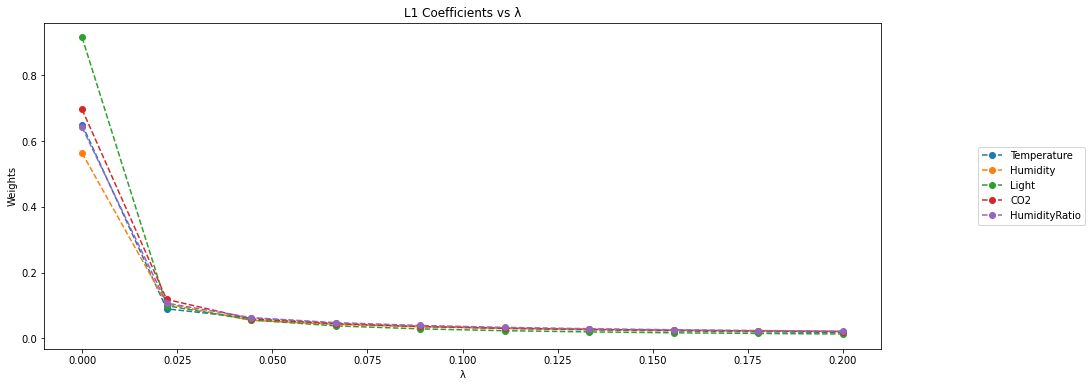

In [ ]:
plt.figure(figsize=[15,6])
for i in range(L1_coef.shape[1]-1):
  x = L1_coef[:,i+1]
  plt.plot(_lambda_array,x,label=columns_label[i],linestyle='--', marker='o')

plt.title("L1 Coefficients vs λ")
plt.legend(loc="right",bbox_to_anchor=(1.25, 0.5))
plt.xlabel("λ")
plt.ylabel("Weights")

Text(0, 0.5, 'Weights')

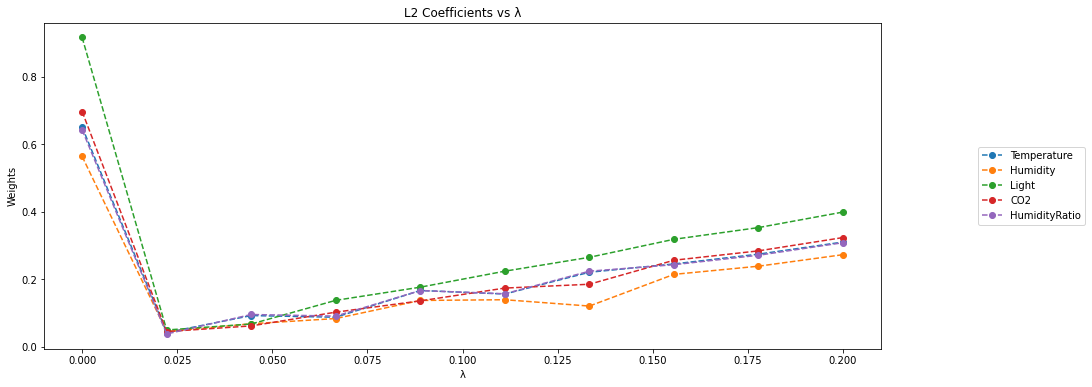

In [ ]:
plt.figure(figsize=[15,6])
for i in range(L2_coef.shape[1]-1):
  y = L2_coef[:,i+1]
  plt.plot(_lambda_array,y,label=columns_label[i],linestyle='--', marker='o')

plt.title("L2 Coefficients vs λ")
plt.legend(loc="right",bbox_to_anchor=(1.25, 0.5))
plt.xlabel("λ")
plt.ylabel("Weights")

### Coefficient Table for All 4 Methods

In [ ]:
coeff_table_occ_index = ["Intercept","Temperature","Humidity","Light","CO2","HumidityRatio"]
stepwise_weight_changed = [stepwise_weight[0],"0","0",stepwise_weight[1],"0","0"] #this is hard-coded based on random state

coeff_table_occ = {"No Regularization": noreg_weight,
            "L1": L1reg_weight,
            "L2": L2reg_weight,
            "Stepwise": stepwise_weight_changed
            }

df_coeff_table_occ = pd.DataFrame(coeff_table_occ, index=coeff_table_occ_index)
df_coeff_table_occ.style

,No Regularization,L1,L2,Stepwise
Intercept,-0.287960,-0.042625,0.003089,-1.377851
Temperature,0.650502,0.212665,0.022835,0
Humidity,0.563537,0.173503,0.027924,0
Light,0.915693,0.248609,0.022956,4.241424
CO2,0.696445,0.217404,0.024985,0
HumidityRatio,0.642119,0.203242,0.023072,0


### Accuracy Table for All 4 Methods and Weights of Step wise

In [ ]:
print("-------------Accuracy Table-------------")
accuracy_array = [baseline*100,noreg_score*100, L1_score*100, L2_score*100, stepwise_score*100]
accuracy_array = [round(a,2) for a in accuracy_array]
accuracy_header = {"Accuracy (%)": accuracy_array}
accuracy_row = ["Baseline","No Reg", "L1", "L2", "Stepwise"]
df_accuracy = pd.DataFrame(accuracy_header, index=accuracy_row)
display(df_accuracy)



-------------Accuracy Table-------------


,Accuracy (%)
Baseline,36.96
No Reg,86.12
L1,86.12
L2,84.62
Stepwise,97.75


### Analysis

For this occupancy dataset, all methods (no regularization, L1, L2, and Forward Stepwise) outperformed the baseline value. The method with the overall highest accuracy is Forward Stepwise. Forward stepwise determined that the predominant feature is "Light", which makes physical sense as if the light is on in a room, there is typically someone inside (would be rather rude to leave the light on if you're leaving the room). Inspecting the coefficient table, "Light" once again is the highest weight for most methods (exluding L2), reinforcing the idea that "Light" is the most relevant feature. The log likelihood plots were also determined, which told one the maximum value, which in turn tells the ideal weights. The L2 plot was very sporadic, while L1 seems to jump around a central value, with no regularization and stepwise achieving a max value, yet decreased shortly after.

## **Multinomial Logistic Regression On UCI Iris Dataset**
Multinomial regression is implemented in the main regression function using the same stochastic gradient descent methods as in non regulairzed case. The gradient function used is equation 4.109 from 4.3.4 of "Pattern Recognition and Machine Learning" by Bishop.

###Regression and Scoring function

In [ ]:
def my_onehot(labels):
  '''
  Onehot encode labels using scikit onehot
  Returns a dataframe of labels of size [features,cats]
  '''
  ohe = OneHotEncoder(sparse=False)
  labels = labels.to_numpy()
  labels = ohe.fit_transform(np.reshape(labels,[-1,1])) # One hot encode y vdctor into matrix of size [numfeatures,numcategories]
  labels = pd.DataFrame(labels)
  return labels

def logistic_multi(x,y,alpha,intercept=True, _type=None,_lambda=None,_plot=True):
  """
  Logistic regression. Outputs coefficient of weights with intercept and max likelihood. Also plots maximum log likelihood
  Input is feature, label, what type of regularization, and hyperparameter _lambda
  """
  if (intercept == True):
    try:
      x.insert(0,'Constant',np.ones((x.shape[0],1))) #Insert ones to first column of training features
    except:
      pass
  num_feature = x.shape[1]
  num_cats = y.shape[1] # Determine number of categories
  '''
  Stochastic gradient descent. Gradient Eq 4.109 of Bishop, "Pattern Recognition and Machine Learning"
  θ(k,i):= θ(k,i) + α* (y(i,k) − hθ(x(i))x(i)
  Implemented in vector form
  '''
  theta=np.zeros([num_cats,num_feature]) # Create weight matrix, num cats by num feature
  for k in range(0,num_cats):
    cur_theta = theta[k,:] # Extract weights for one category
    rows = x.shape[0]
    for i in range(0,rows):
      if _type == None:
        cur_theta += (alpha*(y.iloc[i,k] - h(x.iloc[i,:],cur_theta.T)))*x.iloc[i,:]
      else:
        raise "Specified Method Not Implemented\n"
      theta[k,:] = cur_theta
  return theta

def score_multi(test_feat,test_label,theta,intercept=True,print_output = False):
  """
  Accuracy of label from logistic regression to actual label
  test_feat, label, theta all as cols
  """
  correct = 0
  if intercept == True:
    try:
      test_feat.insert(0,'Constant',np.ones((test_feat.shape[0],1))) #Insert ones to first column of training features
    except:
      pass
  pred = h(test_feat,theta)
  pred[pred>=0.5] = 1
  pred[pred<0.5] = 0

  num_correct = 0
  for j in range(0,test_label.shape[1]):
    for i in range(0,test_label.shape[0]):
      if(pred.iloc[i,j] == test_label.iloc[i,j]):
        num_correct += 1
  accuracy = num_correct/test_label.size
  if(print_output == True):
    print(f"Accuracy of current model is {round(accuracy,2)}\n")
  return accuracy


### Nonregularized multivariate logistic regression on Iris dataset

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn import datasets
import numpy as np
import pandas as pd

iris = datasets.load_iris()
df = pd.DataFrame(iris.data,columns=iris.feature_names)
df.insert(df.columns.shape[0],'label',iris.target)
df = df.sample(frac=1,random_state=1).reset_index(drop=True) #shuffle rows
df_plot_iris = df.copy()
labels = df.pop("label")
df = standardize(df)

# One hot encode labels
labels = my_onehot(labels)

# Train-Test Split (80%-20%)
train_feat_iris = df[:120] #Split training, test, and validation set, 80% training, 10% each for test and validation
test_feat_iris = df[121:]

train_label_iris = labels[:120] # Labels Setup
test_label_iris = labels[121:]

a = logistic_multi(train_feat_iris,train_label_iris,0.1)

score = score_multi(test_feat_iris,test_label_iris,a,print_output=True)

Accuracy of current model is 0.85



### Pair matrix plot on IRIS dataset

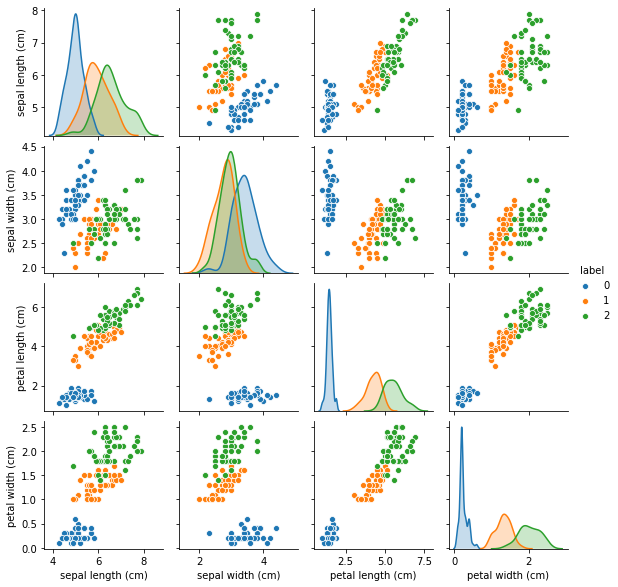

In [ ]:
seaborn.pairplot(df_plot_iris, hue = "label", kind='scatter', diag_kind='kde', height=2, 
                 aspect=1, corner=False, dropna=False, plot_kws=None, diag_kws=None, grid_kws=None, size=None)